In [17]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [18]:
%cd /gdrive/My Drive/AN2DL/Homework1

/gdrive/My Drive/AN2DL/Homework1


### Import libraries

In [19]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [20]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [21]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [26]:
# Download the data
dataset = '/gdrive/My Drive/AN2DL/Homework1/training_dataset_homework1'
training = '/gdrive/My Drive/AN2DL/Homework1/training_dataset_homework1/training'
validation = '/gdrive/My Drive/AN2DL/Homework1/training_dataset_homework1/validation'
test = '/gdrive/My Drive/AN2DL/Homework1/training_dataset_homework1/test'

In [23]:
labels = {
    0:'species1',
    1:'species2',
    2:'species3',
    3:'species4',
    4:'species5',
    5:'species6',
    6:'species7',
    7:'species8'
}

### Process data

In [27]:
# Images are divided into folders, one for each class.
# If the images are organized in such a way, we can exploit the
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed
                                               )
valid_gen = train_data_gen.flow_from_directory(directory=validation,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = train_data_gen.flow_from_directory(directory=test,
                                              target_size=(96,96),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=32,
                                              shuffle=False,
                                              seed=seed)

Found 2671 images belonging to 8 classes.
Found 336 images belonging to 8 classes.
Found 535 images belonging to 8 classes.


In [28]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=20,
                                        horizontal_flip= True,
                                        vertical_flip= True,
                                        brightness_range=(0.6,1.4),
                                        zoom_range=0.6,
                                        fill_mode='nearest',
                                        rescale=1./255) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

Found 2671 images belonging to 8 classes.


### Models metadata

In [29]:
input_shape = (96, 96, 3)
batch_size = 32
epochs = 200

### Standard model

### Transfer learning

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

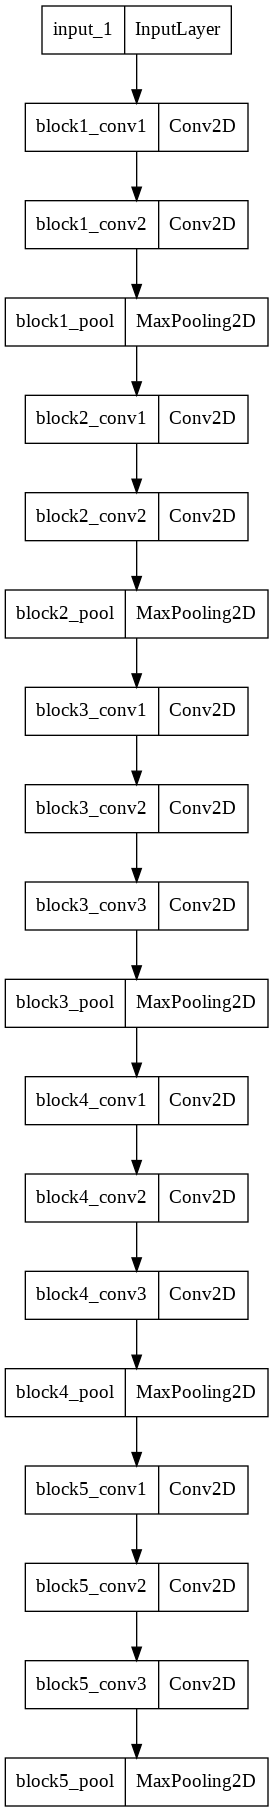

In [30]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [31]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8,
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056  

In [33]:
# Train the model
tl_history = tl_model.fit(
    x = train_gen,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
84/84 [==============================] - 413s 5s/step - loss: 5.5629 - accuracy: 0.3815 - val_loss: 1.5984 - val_accuracy: 0.4375
Epoch 2/200
84/84 [==============================] - 6s 76ms/step - loss: 1.4914 - accuracy: 0.4875 - val_loss: 1.2586 - val_accuracy: 0.5387
Epoch 3/200
84/84 [==============================] - 6s 75ms/step - loss: 1.2671 - accuracy: 0.5687 - val_loss: 1.1791 - val_accuracy: 0.6042
Epoch 4/200
84/84 [==============================] - 6s 75ms/step - loss: 1.1518 - accuracy: 0.6118 - val_loss: 1.1061 - val_accuracy: 0.6071
Epoch 5/200
84/84 [==============================] - 6s 75ms/step - loss: 1.0001 - accuracy: 0.6484 - val_loss: 1.1195 - val_accuracy: 0.6250
Epoch 6/200
84/84 [==============================] - 6s 76ms/step - loss: 0.9437 - accuracy: 0.6660 - val_loss: 1.1429 - val_accuracy: 0.6190
Epoch 7/200
84/84 [==============================] - 6s 76ms/step - loss: 0.8928 - accuracy: 0.6784 - val_loss: 1.1708 - val_accuracy: 0.6518
Epoch 

In [34]:
# Predict the test set with the CNN
predictions = tl_model.predict(test_gen)
predictions.shape

17/17 [==============================] - 80s 5s/step


(535, 8)

In [39]:
# Save the best model
tl_model.save('TransferLearningModel')
del tl_model

In [40]:
model_aug = tfk.models.load_model("TransferLearningModel")
model_aug_test_metrics = model_aug.evaluate(test_gen, return_dict=True)

print()
print("Test metrics with VGG")
print(model_aug_test_metrics)

17/17 [==============================] - 1s 65ms/step - loss: 1.2662 - accuracy: 0.6374

Test metrics with VGG
{'loss': 1.2661807537078857, 'accuracy': 0.6373831629753113}


### Fine tuning

In [41]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056  

In [42]:
# Set all VGG layers to True
ft_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [43]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0        

In [44]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [45]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = train_gen,
    batch_size = 256,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
84/84 [==============================] - 9s 83ms/step - loss: 1.1376 - accuracy: 0.6353 - val_loss: 1.1359 - val_accuracy: 0.6190
Epoch 2/200
84/84 [==============================] - 7s 80ms/step - loss: 0.8685 - accuracy: 0.7057 - val_loss: 1.0276 - val_accuracy: 0.6607
Epoch 3/200
84/84 [==============================] - 7s 79ms/step - loss: 0.7563 - accuracy: 0.7368 - val_loss: 0.9532 - val_accuracy: 0.6994
Epoch 4/200
84/84 [==============================] - 8s 90ms/step - loss: 0.6102 - accuracy: 0.7933 - val_loss: 0.9210 - val_accuracy: 0.7054
Epoch 5/200
84/84 [==============================] - 8s 93ms/step - loss: 0.5600 - accuracy: 0.8023 - val_loss: 0.8428 - val_accuracy: 0.7083
Epoch 6/200
84/84 [==============================] - 7s 77ms/step - loss: 0.4776 - accuracy: 0.8345 - val_loss: 0.9885 - val_accuracy: 0.6964
Epoch 7/200
84/84 [==============================] - 7s 78ms/step - loss: 0.4019 - accuracy: 0.8562 - val_loss: 1.0320 - val_accuracy: 0.7083
Epoch 

In [46]:
ft_model.save('FineTuningModel')
del ft_model

In [47]:
model_aug = tfk.models.load_model("FineTuningModel")
model_aug_test_metrics = model_aug.evaluate(test_gen, return_dict=True)

print()
print("Test metrics with VGG")
print(model_aug_test_metrics)

17/17 [==============================] - 1s 64ms/step - loss: 1.9494 - accuracy: 0.7551

Test metrics with VGG
{'loss': 1.9494404792785645, 'accuracy': 0.7551401853561401}
